<a href="https://colab.research.google.com/github/nikhil-iitb/DerivativePricing_MarketMaking/blob/main/LSTMOnOptions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
file_path = '/content/drive/MyDrive/BTechProject/Data/data.csv'
df = pd.read_csv(file_path)
df.head()

Mounted at /content/drive


,Unnamed: 0,optionid,securityid,strike,callput,date_traded,contract_price,market_price,underlyings_price,contract_volume,days_to_maturity,moneyness,rate,volatility
0,0,150034236.0,504569.0,0.42,C,2006-10-18,0.0715,0.07025,0.488500,5.0,2.0,1.163095,0.053646,0.022956
1,1,150247468.0,504880.0,40.00,C,2006-10-18,0.1240,0.12250,39.913799,56137.0,2.0,0.997845,0.053646,0.114784
2,2,150255000.0,506496.0,62.00,C,2006-10-18,0.1720,0.17400,61.827798,27369.0,2.0,0.997223,0.053646,0.106823
3,3,150255496.0,506497.0,53.50,C,2006-10-18,0.2960,0.26550,53.612900,1224.0,2.0,1.002110,0.053646,0.110336
4,4,150255498.0,506497.0,54.00,C,2006-10-18,0.0750,0.06450,53.612900,963.0,2.0,0.992831,0.053646,0.110336


Eliminating the zero volume data and those options whose maturity is less than 7 days

In [ ]:
count_zero_volume = df[df['contract_volume'] == 0].shape[0]
count_less_than_seven_days = df[(df['days_to_maturity'] < 7)].shape[0]
print("Rows with zero volume ", count_zero_volume)
print("Rows with days to maturity less than 7 days ", count_less_than_seven_days)
print(df.shape)

Rows with zero volume  0
Rows with days to maturity less than 7 days  8409
(107499, 14)


In [ ]:
df_new = df[df['days_to_maturity'] >= 7]

In [ ]:
df_new.shape

(99090, 14)

In [ ]:
count_call = df[df['callput']=='C'].shape[0]
print(count_call)
# All options are call options in given data

107499


In [ ]:
def assign_state(moneyness):
    if moneyness > 1.03:
        return 'ITM'
    elif 0.97 <= moneyness <= 1.03:
        return 'ATM'
    else:
        return 'OTM'

df_new['state'] = df['moneyness'].apply(assign_state)

<ipython-input-6-fd29dd54dd93>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['state'] = df['moneyness'].apply(assign_state)


In [ ]:
df_new.head()

,Unnamed: 0,optionid,securityid,strike,callput,date_traded,contract_price,market_price,underlyings_price,contract_volume,days_to_maturity,moneyness,rate,volatility,state
52,52,150034254.0,504569.0,0.36,C,2006-11-20,0.133,0.1350,0.490000,50.0,116.0,1.361111,0.053935,0.157146,ITM
53,53,150034258.0,504569.0,0.40,C,2006-11-20,0.094,0.0960,0.490000,50.0,116.0,1.225000,0.053935,0.157146,ITM
54,54,150206826.0,504880.0,43.50,C,2006-11-20,0.389,0.3905,40.957500,102.0,116.0,0.941552,0.053935,0.080445,OTM
55,55,150247624.0,504880.0,44.00,C,2006-11-20,0.280,0.2790,40.957500,300.0,116.0,0.930852,0.053935,0.080445,OTM
56,56,150255234.0,506496.0,70.50,C,2006-11-20,0.225,0.2770,64.523301,30.0,116.0,0.915224,0.053935,0.080883,OTM


In [ ]:
grouped_stats = df_new.groupby('state').describe()
grouped_stats

Unnamed: 0                                                       \
           count          mean           std   min       25%      50%   
state                                                                   
ATM      52721.0  59595.782516  29746.066493  61.0  35136.00  60593.0   
ITM       6312.0  22682.444708  13905.231988  52.0  11971.25  24722.0   
OTM      40057.0  50434.744789  31262.882108  54.0  21164.00  49899.0   

                         optionid                ...      rate            \
           75%       max    count          mean  ...       75%       max   
state                                            ...                       
ATM    85472.0  108021.0  52721.0  1.585230e+08  ...  0.030537  0.058757   
ITM    31632.5  107999.0   6312.0  1.521353e+08  ...  0.053925  0.058624   
OTM    74195.0  108024.0  40057.0  1.570073e+08  ...  0.051434  0.058476   

      volatility                                                         \
           count      mean       std  min       25%       50%       75%   
state                                                                     
ATM      52721.0  0.157324  0.075221  0.0  0.108065  0.137587  0.182504   
ITM       6312.0  0.179876  0.108940  0.0  0.106059  0.161177  0.236241   
OTM      40057.0  0.186137  0.097137  0.0  0.120367  0.159178  0.228574   

                 
            max  
state            
ATM    0.696639  
ITM    0.612214  
OTM    0.946255  

[3 rows x 96 columns]

In [ ]:
df_new['days_to_maturity'] = df_new['days_to_maturity']/365

<ipython-input-9-671c6c0897e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['days_to_maturity'] = df_new['days_to_maturity']/365


In [ ]:
df_new.head()

,Unnamed: 0,optionid,securityid,strike,callput,date_traded,contract_price,market_price,underlyings_price,contract_volume,days_to_maturity,moneyness,rate,volatility,state
52,52,150034254.0,504569.0,0.36,C,2006-11-20,0.133,0.1350,0.490000,50.0,0.317808,1.361111,0.053935,0.157146,ITM
53,53,150034258.0,504569.0,0.40,C,2006-11-20,0.094,0.0960,0.490000,50.0,0.317808,1.225000,0.053935,0.157146,ITM
54,54,150206826.0,504880.0,43.50,C,2006-11-20,0.389,0.3905,40.957500,102.0,0.317808,0.941552,0.053935,0.080445,OTM
55,55,150247624.0,504880.0,44.00,C,2006-11-20,0.280,0.2790,40.957500,300.0,0.317808,0.930852,0.053935,0.080445,OTM
56,56,150255234.0,506496.0,70.50,C,2006-11-20,0.225,0.2770,64.523301,30.0,0.317808,0.915224,0.053935,0.080883,OTM


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.activations import relu
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [ ]:
data = df_new.drop(['callput','date_traded','optionid','state','securityid','market_price','contract_volume','moneyness'], axis=1)

In [ ]:
data = data.iloc[:,1:]

In [ ]:
data

,strike,contract_price,underlyings_price,days_to_maturity,rate,volatility
52,0.36,0.133,0.490000,0.317808,0.053935,0.157146
53,0.40,0.094,0.490000,0.317808,0.053935,0.157146
54,43.50,0.389,40.957500,0.317808,0.053935,0.080445
55,44.00,0.280,40.957500,0.317808,0.053935,0.080445
56,70.50,0.225,64.523301,0.317808,0.053935,0.080883
...,...,...,...,...,...,...
107494,10.60,0.075,10.130000,0.158904,0.001108,0.184646
107495,11.20,0.092,11.097500,0.104110,0.026018,0.093048
107496,12.00,0.097,11.400000,0.249315,0.022493,0.161584
107497,13.20,0.094,12.767500,0.219178,0.017113,0.153323


In [ ]:
# Find the index of the 'contract_price' column
contract_price_idx = data.columns.get_loc('contract_price')

# Move the 'contract_price' column to the last position
cols = list(data.columns)
cols.pop(contract_price_idx)
cols.append('contract_price')
data = data[cols]

In [ ]:
data.head()

,strike,underlyings_price,days_to_maturity,rate,volatility,contract_price
52,0.36,0.490000,0.317808,0.053935,0.157146,0.133
53,0.40,0.490000,0.317808,0.053935,0.157146,0.094
54,43.50,40.957500,0.317808,0.053935,0.080445,0.389
55,44.00,40.957500,0.317808,0.053935,0.080445,0.280
56,70.50,64.523301,0.317808,0.053935,0.080883,0.225


In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [ ]:
scaled_data

array([[0.00000000e+00, 2.28331354e-05, 3.04469274e-01, 9.17085945e-01,
        1.66071104e-01, 2.36439118e-01],
       [7.69763683e-05, 2.28331354e-05, 3.04469274e-01, 9.17085945e-01,
        1.66071104e-01, 1.24803201e-01],
       [8.30190132e-02, 9.24228240e-02, 3.04469274e-01, 9.17085945e-01,
        8.50141569e-02, 9.69228653e-01],
       ...,
       [2.24001232e-02, 2.49337839e-02, 2.34636872e-01, 3.76433625e-01,
        1.70761806e-01, 1.33390584e-01],
       [2.47094142e-02, 2.80562152e-02, 2.03910615e-01, 2.83937047e-01,
        1.62031420e-01, 1.24803201e-01],
       [2.85582326e-02, 3.10679063e-02, 1.75977654e-01, 2.77888873e-02,
        1.69549881e-01, 1.36253054e-01]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data[:, :-1], scaled_data[:, -1], test_size=0.2, shuffle=False)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(200, return_sequences=True),
    Dropout(0.2),
    LSTM(200, return_sequences=True),
    Dropout(0.2),
    LSTM(200, return_sequences=True),
    Dropout(0.2),
    LSTM(200, return_sequences=True),
    Dropout(0.2),
    LSTM(200),
    Dropout(0.2),
    Dense(1)
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

# Define a model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/BTechProject/Models/option_lstm_model_checkpoint.h5',  # Path to save the model checkpoint
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    save_weights_only=False,  # Save entire model, not just weights
    mode='min',  # Minimize validation loss
    verbose=1
)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
1239/1239 [==============================] - 30s 12ms/step - loss: 0.0779 - val_loss: 0.0868
Epoch 2/100
1239/1239 [==============================] - 13s 10ms/step - loss: 0.0763 - val_loss: 0.1662
Epoch 3/100
1239/1239 [==============================] - 13s 10ms/step - loss: 0.0758 - val_loss: 0.1052
Epoch 4/100
1239/1239 [==============================] - 13s 10ms/step - loss: 0.0756 - val_loss: 0.1045
Epoch 5/100
1239/1239 [==============================] - 13s 10ms/step - loss: 0.0755 - val_loss: 0.0904
Epoch 6/100
1239/1239 [==============================] - 13s 11ms/step - loss: 0.0754 - val_loss: 0.0894
Epoch 7/100
1239/1239 [==============================] - 13s 10ms/step - loss: 0.0754 - val_loss: 0.0977
Epoch 8/100
1239/1239 [==============================] - 13s 10ms/step - loss: 0.0753 - val_loss: 0.0873
Epoch 9/100
1239/1239 [==============================] - 13s 10ms/step - loss: 0.0752 - val_loss: 0.1030
Epoch 10/100
1239/1239 [==============================]

In [ ]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")

620/620 [==============================] - 2s 4ms/step - loss: 0.0604
Test Loss: 0.0604


## VISUALISATION OF RESULTS

In [ ]:
predicted_prices = model.predict(X_test)

620/620 [==============================] - 4s 4ms/step


MAPE: 173.32%


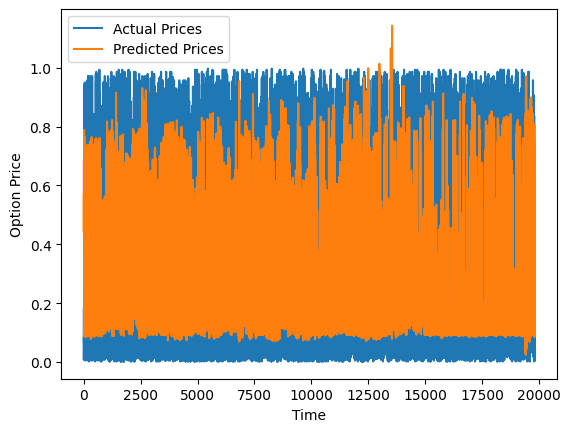

In [ ]:
# Calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = calculate_mape(y_test.reshape(-1, 1), predicted_prices)

print(f"MAPE: {mape:.2f}%")

# Plot training and validation loss
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# Visualize predicted vs. actual prices
plt.plot(y_test.reshape(-1, 1), label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Option Price')
plt.legend()
plt.show()

In [ ]:
scaler.inverse_transform(predicted_prices).shape

ValueError: ignored

In [ ]:
predicted_prices.shape